## Fugacity of saturated steam

**Saturated steam** is a steam condition where both phases (liquid and gaseous) of water exist simultaneously for a certain condition of pressure and temperature. This can be accomplished when fugacity coefficient of the two phases are the same:

* $ ln(\phi_l) = ln(\phi_v) $

Once this condition is obtained, the value of fugacity coefficient can be used to calculate fugacity of **saturated steam**:

* $ f = \phi*P $

For this problem we don't know the correct value of temperature for saturation condition. For this reason we must to use optimization tool in order to find the optimum temperature that satisfies the first equation. This is reached when the objective function is minimizated:

* $ g(T) = (ln(\phi_l(T)) - ln(\phi_v(T)))^2 $

The $ ln(\phi) $ can be obtained by state equations where a famous one is **Peng-Robinson**:

* $ P = \frac{RT}{V_m-b} - \frac{a\alpha}{V_m^2+2bV_m-b^2} $

Where:

$ \begin{cases}a = \frac{0.45724R^2T_c^2}{P_c}\\
b = \frac{(0.07780RT_c)}{P_c}\\
f_w = 0.37464 + 1.5422w - 0.26992w^2\\
\alpha = (1 + f_w * (1 - T_r^{0.5}))^2\\
T_r = \frac{T}{Tc}\end{cases} $

However, the first assignment is to find the molar volume of liquid and gaseous phases (by Peng-Robinson equation) to use they on $ ln(\phi) $ calculation. This is accomplished by zeros of function approximation. The entire process to find **fugacity** in a certain pressure is:

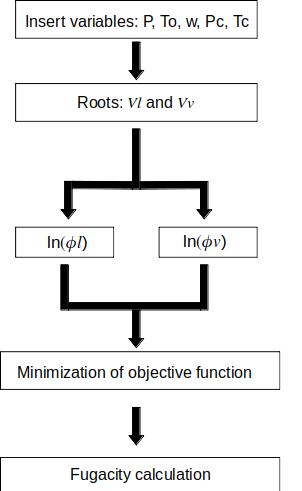

In [1]:
import numpy as np
from sympy import *

In [2]:
#-------------- Variable to find in zero of function approximation ------------------#
V = symbols('V') 

In [3]:
#---------------------------------- Peng-Robinson -----------------------------------#

def PengRob(R, Tc, Pc, w, P, T):

    Tr   = T/Tc
    fw   = 0.37464 + (1.5422*w) - (0.26992*(w**2))
    alfa = (1 + fw * (1 - (Tr**0.5)))**2
    a    = 0.45724 * ((R * Tc)**2)/Pc
    b    = 0.07780 * (R * Tc)/Pc
    
    f = (((R * T)/(V - b)) - ((a * alfa)/((V * (V + b)) + (b * (V - b)))) - P)**2
    
    return f

In [4]:
#---------------------------------- Molar volume ------------------------------------#

def roots (R, Tc, Pc, w, P, T):
    
    V_l, _, V_v = solveset(PengRob(R, Tc, Pc, w, P, T), V, S.Reals)
    
    return V_l, V_v

In [5]:
#------------------------------------ Ln(phi) ---------------------------------------#

def Lnphi (R, Tc, Pc, w, P, T): 
    
    V_l, V_v    = roots (R, Tc, Pc, w, P, T)
    Tr   = T/Tc
    fw   = 0.37464 + (1.5422*w) - (0.26992*(w**2))
    alfa = (1 + fw * (1 - (Tr**0.5)))**2
    a    = float(0.45724 * ((R * Tc)**2)/Pc)
    b    = float(0.07780 * (R * Tc)/Pc)
    h_l  = float(b/V_l)
    h_v  = float(b/V_v)
    fi   = float(a * alfa)
    Z_l  = float((P * V_l)/(R * T))
    Z_v  = float((P * V_v)/(R * T))
    
    coefug_l = Z_l - 1 - np.log(Z_l*(1-h_l)) - (((fi/(b*R*T))/(2*np.sqrt(2)))*np.log((1+(1+np.sqrt(2))*h_l)/(1+(1-np.sqrt(2))*h_l)))
    coefug_v = Z_v - 1 - np.log(Z_v*(1-h_v)) - (((fi/(b*R*T))/(2*np.sqrt(2)))*np.log((1+(1+np.sqrt(2))*h_v)/(1+(1-np.sqrt(2))*h_v)))
    
    #----------------- Fobj --------------------#
    f = -(coefug_l - coefug_v)**2
        
    
    return f, coefug_l, coefug_v

In [6]:
#------------------------------------ Optimization -----------------------------------#

def sec_aurea(Tu, Tl, tol):
    
    R = ((np.sqrt(5)-1)/2)
    d = R * (Tu-Tl)
    T1 = Tl + d
    T2 = Tu - d
    
    f1 = Lnphi (R, Tc, Pc, w, P, T1)
    f2 = Lnphi (R, Tc, Pc, w, P, T2)
    
    erro = (1-R) * abs((Tu-Tl)/T2)
    
    while(erro > tol):
        
        if f1>f2:
        
            Tl = T2
            T2 = T1
            d = ((np.sqrt(5)-1)/2)*(Tu-Tl)
            T1 = Tl + d
            f1,_,_ = Lnphi (R, Tc, Pc, w, P, T1)
            f2,_,_ = Lnphi (R, Tc, Pc, w, P, T2)
            erro = (1-R) * abs((Tu-Tl)/T2)
            
        if f1<f2:
        
            Tu = T1
            T1 = T2
            d = ((np.sqrt(5)-1)/2)*(Tu-Tl)
            T2 = Tu - d
            f1,_,_ = Lnphi (R, Tc, Pc, w, P, T1)
            f2,_,_ = Lnphi (R, Tc, Pc, w, P, T2)
            erro = (1-R) * abs((Tu-Tl)/T2)
            
        
    return T2

In [8]:
#-------------------------------------- Variables of problem --------------------------------------#
R  = 83.14  #cm³*bar/mol*K
Tc = 647.3  #K
Pc = 220.48 #bar
w  = 0.344
P  = 5  #bar

#--------------------------------------- ln(phi) calculation ----------------------------------------#
Tu = 400 #K
Tl = 500 #K
T = sec_aurea(Tu, Tl, 1e-5)
_,lnphi_l,lnphi_v = Lnphi (R, Tc, Pc, w, P, T)


#------------------------------------- Fugacity calculation ---------------------------------------#
phi = np.exp(lnphi_l)
fugacity = phi * P

#------------------------------------------ Results ----------------------------------------------#
print("Temperature value for saturated steam in a pressure of",P,"bar:", T,"K")
print("Fugacity coefficient in liquid phase:",lnphi_l)
print("Fugacity coefficient in gaseous phase:",lnphi_v)
print("Fugacity in a pressure of",P,"bar:",fugacity)

Temperature value for saturated steam in a pressure of 5 bar: 425.6249685160372
Fugacity coefficient in liquid phase: -0.03019509485074856
Fugacity coefficient in gaseous phase: -0.03024325626189761
Fugacity in a pressure of 5 bar: 4.851281115446646
